# Lab 07: Abstracts of Scientific Articles (2/2)
In this lab we will continue working with topic models, but this time with a new dataset. Instead of abstracts of scientific articles, we will create topic models over movie plot descriptions. This is a dataset containing descriptions of movies from Wikipedia. The dataset was [obtained](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) from Kaggle, an online community of data scientists.

We will review the Counter class and how to build vocabularies again, and get practice with building topic models for new datasets. We'll also introduce the concept of stemming and lemmatization. 

Spoiler alert for the movie "[Husbands and Wives](https://en.wikipedia.org/wiki/Husbands_and_Wives)"!

In [1]:
from datascience import *
import numpy as np
import re
import gensim

from collections import Counter

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.root.level = logging.CRITICAL 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

This time round, the movie plot descriptions are in a CSV format in `movie_plots.csv`. The file is hosted on the Amazon Web Service s3. We'll use the `datascience` package to read this CSV file.

The CSV file is rather large, so we'll randomly sample only 10000 rows, skipping over the others during the loading process. We could have sampled the rows after loading the entire CSV file, but this method saves memory. 

In [2]:
np.random.seed(101)

total_size = 34886
sample_size = 10000
sample_rows = np.random.choice(range(1,total_size+2), sample_size, replace=False)
skip_rows = np.setdiff1d(range(1,total_size+2), sample_rows)

filename = "https://s3.amazonaws.com/sds171/labs/lab07/movie_plots.csv"
data = Table.read_table(filename, skiprows=skip_rows)
data.show(5)

Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
1901,Kansas Saloon Smashers,American,Unknown,nan,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Smashers,"A bartender is working at a saloon, serving drinks to cu ..."
1901,Love by the Light of the Moon,American,Unknown,nan,unknown,https://en.wikipedia.org/wiki/Love_by_the_Light_of_the_Moon,"The moon, painted with a smiling face hangs over a park ..."
1901,The Martyred Presidents,American,Unknown,nan,unknown,https://en.wikipedia.org/wiki/The_Martyred_Presidents,"The film, just over a minute long, is composed of two sh ..."
1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderland_(1903_ ...,"Alice follows a large white rabbit down a ""Rabbit-hole"". ..."
1904,The Suburbanite,American,Wallace McCutcheon,nan,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,"The film is about a family who move to the suburbs, hopi ..."


The data is now in the `Table` format, which we are familiar with. We are only concerned with the plots, so we will extract them from the `Table`.

In [3]:
sample = 3402

plots = data.column('Plot')
    
print("Number of documents: %d\n" % len(plots))
print(plots[sample])

Number of documents: 10000

The film is about two couples: Jack (Pollack) and Sally (Davis), and Gabe (Allen) and Judy (Farrow). The film starts when Jack and Sally arrive at Gabe and Judy's apartment and announce their separation. Gabe is shocked, but Judy takes the news personally and is very hurt. Still confused, they go out for dinner at a Chinese restaurant.
A few weeks later Sally goes to the apartment of a colleague. They plan to go out together to the opera and then to dinner. Sally asks if she can use his phone, and calls Jack. Learning from him that he has met someone, she accuses him of having had an affair during their marriage.
Judy and Gabe are introduced to Jack's new girlfriend, Sam, an aerobics trainer. While Judy and Sam shop, Gabe calls Jack's new girlfriend a "cocktail waitress" and tells him that he is crazy for leaving Sally for her. About a week later, Judy introduces Sally to Michael (Neeson), Judy's magazine colleague who she clearly is interested in herself. M

This plot description is from the movie "[Husbands and Wives](https://en.wikipedia.org/wiki/Husbands_and_Wives)"

We don't have LaTeX markup in these documents, so we can use regex to do some simpe pre-processing of punctuation. There are lots of names in the plot descriptions, so we'll remove all the words that have a capitalized first letter. This will remove lots of non-name words as well, but this'll be sufficient for our purposes.

In [4]:
# replace '-' with ' ', then remove punctuation
plots = [re.sub(r'-', ' ', plot) for plot in plots]
plots = [re.sub(r'[^\w\s]', '', plot) for plot in plots]

# remove tokens with a capitalized first letter 
# (broad stroke to remove names)
plots = [re.sub(r'[A-Z]\w*', '', plot) for plot in plots]

print(plots[sample])

 film is about two couples   and   and   and    film starts when  and  arrive at  and  apartment and announce their separation  is shocked but  takes the news personally and is very hurt  confused they go out for dinner at a  restaurant
 few weeks later  goes to the apartment of a colleague  plan to go out together to the opera and then to dinner  asks if she can use his phone and calls   from him that he has met someone she accuses him of having had an affair during their marriage
 and  are introduced to  new girlfriend  an aerobics trainer   and  shop  calls  new girlfriend a cocktail waitress and tells him that he is crazy for leaving  for her  a week later  introduces  to    magazine colleague who she clearly is interested in herself  asks  out and they begin dating  is smitten but  is dissatisfied with the relationship
  has developed a friendship with a young student of his  and has her read the manuscript of his novel  comments on its brilliance but has several criticisms to whi

Now, we want to further process each plot description by converting it to lower case, stripping leading and trailing white space, and then tokenizing by splitting on spaces.

In [5]:
plots_tok = []
for plot in plots:
    processed = plot.lower().strip().split(' ')
    plots_tok.append(processed)

Furthermore, we will remove tokens that have digits, have possessives or contractions, or are empty strings.
- `is_numeric(string)` checks if `string` has any numbers
- `has_poss_contr(string)` checks if `string` has possessives or contractions
- `empty_string(string)` checks if `string` is an empty string
- `remove_string(string)` checcks if `string` should be removed

In [6]:
def is_numeric(string):
    for char in string:
        if char.isdigit():
            return True
    return False

def has_poss_contr(string):
    for i in range(len(string) - 1):
        if string[i] == '\'' and string[i+1] == 's':
            return True
    return False

def empty_string(string):
    return string == ''

def remove_string(string):
    return is_numeric(string) | has_poss_contr(string) | empty_string(string)

In [7]:
temp = []
for plot in plots_tok:
    filtered = []
    for token in plot:
        if not remove_string(token):
            filtered.append(token)
    temp.append(filtered)
plots_tok = temp

Recall that to build topic models, we require the following components:
- A vocabulary of tokens that appear across all documents.
- A mapping of those tokens to a unique integer identifier, because topic model algorithms treat words by these identifiers, and not the strings themselves. For example, we represent `'epidemic'` as `word2id['epidemic'] = 50`
- The corpus, where each document in the corpus is a collection of tokens, where each token is represented by the identifier and the number of times it appears in the document. For example, in the first document above the token `'epidemic'`, which appears twice, is represented as `(50, 2)`

First, we will build a vocabulary representing the tokens that have appeared across all the plot descriptions we have. When doing this, we typically want to (1) remove rare words, (2) remove stop words and (3) stem/lemmatize words.

Let's introduce the concept of stemming and lemmatization. Both are techniques to derive the root form of a word (`'run'`), given an inflected form of the word (`'running'`).

**Stemming**. This is the process of shortening a word based on common heuristics, such as removing suffixes. For example, `'appeared'` -> `'appear'`. Sometimes, there is nothing to remove, like in `'saw'` -> `'saw'`.

**Lemmatization**. This is the process of deriving the root word based on its part of speech and word morphology. For example, `'saw'` -> `'saw'` if it is used as a noun, but `'saw'` -> `'see'` if it is used as a verb.

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

temp = []
for plot in plots_tok:
    processed = []
    for token in plot:
        processed.append(lemmatizer.lemmatize(token, pos='v'))
    temp.append(processed)
plots_tok = temp

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Recall that we can use the `Counter` class to build the vocabulary. The `Counter` is an extension of the Python dictionary, and also has key-value pairs. For the `Counter`, keys are the objects to be counted, while values are their counts.

In [13]:
vocab = Counter()
for plot in plots_tok:
    vocab.update(plot)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 33686


Recall that removing rare words helps prevent our vocabulary from being too large. Many tokens appear only a few times across all the plot descriptions. Keeping them in the vocabulary increases subsequent computation time. Furthermore, their presence tends not to carry much significance for a document, since they can be considered as anomalies.

We remove rare words by only keeping tokens that appear more than 25 times across all plot descriptions.

In [14]:
tokens = []
for token in vocab.elements():
    if vocab[token] > 25:
        tokens.append(token)
vocab = Counter(tokens)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 5586


Recall that stop words are defined as very common words such as `'the'` and `'a'`. Removing stop words is important because their presence also does not carry much significance, since they appear in all kinds of texts.

We will remove stop words by removing the 200 most common tokens across all the plot descriptions.

In [15]:
stop_words = []
for item in vocab.most_common(200):
    stop_word = item[0]
    stop_words.append(stop_word)
tokens = []
for token in vocab.elements():
    if token not in stop_words:
        tokens.append(token)
vocab = Counter(tokens)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 5386


Now we create a mapping for tokens to unique identifiers. 

In [16]:
items = vocab.items()
id2word = {}
word2id = {}
idx = 0
for word, count in vocab.items():
    id2word[idx] = word
    word2id[word] = idx
    idx += 1
    
print("Number of tokens mapped: %d" % len(id2word))
print("Identifier for 'photograph': %d" % word2id['photograph'])
print("Word for identifier %d: %s" % (word2id['photograph'], id2word[word2id['photograph']]))

Number of tokens mapped: 5386
Identifier for 'photograph': 2152
Word for identifier 2152: photograph


Now, we will remove, for each plot description, the tokens that are not found in our vocabulary.

In [17]:
temp = []
for plot in plots_tok:
    filtered = []
    for token in plot:
        if token in vocab:
            filtered.append(token)
    temp.append(filtered)
plots_tok = temp

Let's create the corpus. Recall that for the tokens in a plot description:

```
['doctor', 'pearson', 'michael', 'rennie', 'canadian', 'hospital', 'province', 'quebec', 'receive', 'series', 'poison', 'pen', 'letter', 'letter', 'sign', 'mysterious', 'picture', 'feather', 'deliver', 'others', 'small', 'canadian', 'cora', 'laurent', 'constance', 'smith', 'main', 'doctor', 'dr', 'laurent', 'charles', 'boyer', 'hospital', 'receive', 'letter', 'accuse', 'affair', 'pearson', 'letter', 'inform', 'shell', 'shock', 'veteran', 'mr', 'cancer', 'distraught', 'commit', 'suicide', 'quickly', 'townsfolk', 'point', 'finger', 'possible', 'suspect'] 
```
the corpus has the format
```
[(1841, 2), (2095, 2), (2096, 1), (2097, 1), (2098, 2), (105, 2), (2099, 1), (2100, 1), (270, 2), (1763, 1), (1870, 1), (2101, 1), (2017, 4), (633, 1), (1270, 1), (1093, 1), (2102, 1), (1197, 1), (113, 1), (1583, 1), (2103, 1), (2104, 2), (2105, 1), (873, 1), (1950, 1), (107, 1), (2106, 1), (2107, 1), (116, 1), (1436, 1), (62, 1), (2108, 1), (213, 1), (2109, 1), (1205, 1), (2110, 1), (1042, 1), (1275, 1), (1259, 1), (1342, 1), (2111, 1), (440, 1), (1662, 1), (374, 1), (663, 1)]
```

where each element is a pair containing the identifier for the token and the count of that token in just that plot description.

In [18]:
corpus = []
for plot in plots_tok:
    plot_count = Counter(plot)
    corpus_doc = []
    for item in plot_count.items():
        pair = (word2id[item[0]], item[1])
        corpus_doc.append(pair)
    corpus.append(corpus_doc)

print("Plot, tokenized:\n", plots_tok[sample], "\n")
print("Plot, in corpus format:\n", corpus[sample])

Plot, tokenized:
 ['couple', 'apartment', 'announce', 'separation', 'shock', 'news', 'personally', 'very', 'hurt', 'confuse', 'dinner', 'few', 'weeks', 'apartment', 'colleague', 'together', 'opera', 'dinner', 'phone', 'someone', 'accuse', 'affair', 'marriage\r\n', 'introduce', 'girlfriend', 'trainer', 'shop', 'girlfriend', 'waitress', 'crazy', 'week', 'introduce', 'magazine', 'colleague', 'clearly', 'interest', 'herself', 'date', 'smite', 'relationship\r\n', 'develop', 'friendship', 'student', 'read', 'manuscript', 'novel', 'comment', 'several', 'react', 'party', 'someone', 'fly', 'jealous', 'rage', 'intense', 'argument', 'bed', 'marriage', 'chance', 'leave\r\n', 'than', 'weeks', 'however', 'together', 'couple', 'dinner', 'dinner', 'argument', 'share', 'poetry', 'fail', 'pass', 'think', 'relationship', 'week', 'birthday', 'party', 'music', 'box', 'present', 'kiss', 'though', 'share', 'romantic', 'moment', 'should', 'pursue', 'any', 'further', 'walk', 'rain', 'ruin', 'relationship', 'ne

Now, we are ready to create our topic model!

We again use gensim, a Python library to create topic models. Also, we again use the algorithm called latent dirichlet allocation implemented in the gensim library. 

**This step takes about 40s**

In [19]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

CPU times: user 38.4 s, sys: 9.73 ms, total: 38.4 s
Wall time: 38.4 s


After building the topic model, we want to view the 10 topics. The topics are represented as a combination of keywords with corresponding weight on the keyword. Note that the order of these topics can change between different training runs of the topic model, since there is no ordering between topics and gensim returns them in an arbitrary order.

In [20]:
num_topics = 10
num_words = 15
top_words = Table().with_column('word rank', np.arange(1,num_words+1))
for k in np.arange(num_topics): 
    topic = lda_model.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words = top_words.with_column('topic %d' % k, words)
    
top_words.show()

word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
1,officer,win,power,village,marriage,movie,gang,ship,battle,body
2,case,team,destroy,sister,feel,accident,company,island,city,appear
3,arrest,college,world,hospital,how,girls,local,matter,rescue,enter
4,dead,high,child,student,parent,dream,business,project,land,open
5,though,join,boy,doctor,very,rich,revenge,sea,travel,search
6,commit,students,children,villagers,stay,act,brothers,boat,defeat,chase
7,leader,members,baby,spirit,together,around,kidnap,million,encounter,hide
8,truth,final,ghost,teacher,happen,character,sell,wealth,human,throw
9,former,second,always,uncle,accept,perform,jail,crew,soldier,reach
10,under,henchmen,create,due,too,scene,law,launch,temple,inside


We can compute the probability distribution for a given plot description in the `corpus`. This represents how likely it is for the plot description to belong to each topic.

In [21]:
sample = 3402
lda_model.get_document_topics(corpus[sample], minimum_probability=0)

[(0, 0.0799971),
 (1, 0.083626099),
 (2, 0.040867072),
 (3, 0.034000255),
 (4, 0.52988881),
 (5, 0.081525929),
 (6, 0.06373515),
 (7, 0.010502912),
 (8, 0.024644673),
 (9, 0.051212043)]

Let's represent this as a table.

In [22]:
topic_dist = lda_model.get_document_topics(corpus[sample], minimum_probability=0)
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = Table().with_columns('Topic', topics, 'Probabilities', probabilities)
topic_dist_table.show(20)
t = np.argmax(probabilities)
print("Topic with highest probability: %d (%f)" % (t, probabilities[t]))

Topic,Probabilities
0,0.0799951
1,0.0836254
2,0.0408732
3,0.0340003
4,0.529889
5,0.0815253
6,0.0637311
7,0.0105029
8,0.0246447
9,0.0512127


Topic with highest probability: 4 (0.529889)


And now as a histogram.

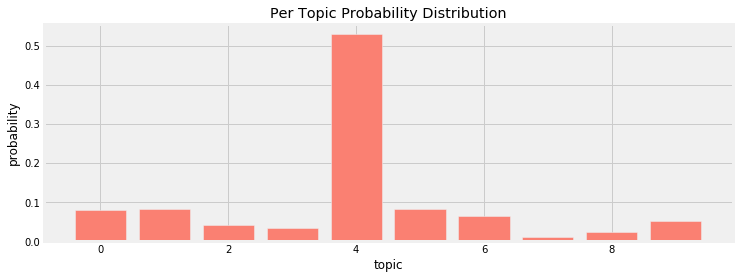

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(11,4)
plt.bar(topic_dist_table.column('Topic'), topic_dist_table.column('Probabilities'), align='center', alpha=1, color='salmon')
plt.xlabel('topic')
plt.ylabel('probability')
plt.title('Per Topic Probability Distribution')
plt.show()

So it seems the movie plot description

```
The film is about two couples: Jack (Pollack) and Sally (Davis), and Gabe (Allen) and Judy (Farrow). The film starts when Jack and Sally arrive at Gabe and Judy's apartment and announce their separation. Gabe is shocked, but Judy takes the news personally and is very hurt. Still confused, they go out for dinner at a Chinese restaurant.
A few weeks later Sally goes to the apartment of a colleague. They plan to go out together to the opera and then to dinner. Sally asks if she can use his phone, and calls Jack. Learning from him that he has met someone, she accuses him of having had an affair during their marriage.
Judy and Gabe are introduced to Jack's new girlfriend, Sam, an aerobics trainer. While Judy and Sam shop, Gabe calls Jack's new girlfriend a "cocktail waitress" and tells him that he is crazy for leaving Sally for her. About a week later, Judy introduces Sally to Michael (Neeson), Judy's magazine colleague who she clearly is interested in herself. Michael asks Sally out, and they begin dating; Michael is smitten, but Sally is dissatisfied with the relationship.
Meanwhile, Gabe has developed a friendship with a young student of his, Rain, and has her read the manuscript of his novel. She comments on its brilliance, but has several criticisms, to which Gabe reacts defensively.
At a party, Jack learns from a friend that Sally is seeing someone, and flies into a jealous rage. He and Sam break up after an intense argument, and Jack drives back to his house to find Sally in bed with Michael. He asks Sally to give their marriage another chance, but she tells him to leave.
Less than two weeks later, however, Jack and Sally are back together and the couple meet Judy and Gabe for dinner like old times. After dinner, Judy and Gabe get into an argument about her not sharing her poetry. After Gabe makes a failed pass at her, Judy tells him she thinks the relationship is over; a week later Gabe moves out. Judy begins seeing Michael.
Gabe goes to Rain's 21st birthday party, and gives her a music box as a present. She asks him to kiss her, and though the two share a romantic moment, Gabe tells her they should not pursue it any further. As he walks home in the rain, he realizes that he has ruined his relationship with Judy.
Michael tells Judy he needs time alone, then says he can't help still having feelings for Sally. Angry and hurt, Judy walks out into the rain. Highlighting her "passive aggressiveness," Michael follows and begs her to stay with him. A year and a half later they marry.
At the end, the audience sees a pensive Jack and Sally back together. Jack and Sally admit their marital problems still exist (her frigidity is not solved), but they find they accept their problems as simply the price they have to pay to remain together.
Gabe is living alone because he says he is not dating for the time being, as he does not want to hurt anyone. The film ends with an immediate cut to black after Gabe asks the unseen documentary crew, "Can I go? Is this over?"
```

has the greatest likelihood to fall under the topic number with topic relating to relationships, which matches our intuition.

## Topic Models for TED Talk Transcripts

*Your turn!* Your task is broken down into two parts.

#### 1. Run Topic Models
You are given a new dataset of transcripts of TED Talks. This dataset is also [obtained](https://www.kaggle.com/rounakbanik/ted-talks) from Kaggle. You can use the following link to load the data, in a CSV file `ted_talks.csv`, from s3:

```
filename = "https://s3.amazonaws.com/sds171/labs/lab07/ted_talks.csv"
data = Table.read_table(filename)
```

Run the code above to train a topic model over this new dataset. In particular,
- Load the CSV file. You can simply use the two lines of code above, without skipping any rows.
- Preprocess
    - Discard some transcripts if you find it appropriate.
    - Add a regular expression here if you find it is appropriate.
    - Tokenize and remove numerics, possessives/contractions, and empty strings
    - Lemmatize tokens
- Create a vocabulary using a `Counter`
- Filter the vocabulary by removing rare words and stop words. You should be getting a final vocabulary size of about 7000.
- Create the identifier mappings `word2id` and `id2word`
- Filter tokens from the tokenized data using the final vocabulary
- Create the corpus
- Train the topic model
- Show the topics along with the top words

You should find yourself simply using the code given above for this new dataset. Very few changes are necessary!


#### 2. Discussion
Discuss the results. Choose two or three articles and describe how the most probable topic does or does not seem to accurately represent the main theme of the paper. Include your comments in Markdown cell, with code cells added as needed to pull out particular rows of your table. You may find it useful to copy over the code for `create_topic_table` from the previous lab.